# Overview

This Jupyter notebook accompanies the manuscript of Zheng et al. titled "A two-layered ecosystem model for the stratified ocean". It demonstrates how to run the two-layered ecosystem model to output the nutrients, phytoplankton and zooplankton concentration daily timeseries at two layers at Bermuda Atlantic Time-series Study site (BATS).

Please note that this example is designed such that each cell (block of Python code) is run after the previous cell. If you clear or restart, you will need to run through each cell from the start.

# Forcing

The input forcing for this model is Mixed Layer Depth daily timeseries from 1991 to 2021 at BATS. A full description of this forcing is provided in the manuscript.

# Model

A full description of the two-layered ecosystem model and the needed parameters have been presented in the manuscript. The Python codes for the two-layered ecosystem model with output in concentration will be defined below (see 2. Define the two-layered ecosystem model). 

# Run the model in the unit of concentration

### 1. Load packages needed for notebook

In [1]:
import numpy  as np
import pandas as pd
import math   as mt
import matplotlib.dates  as mdates
import matplotlib.pyplot as plt
import calendar
from   matplotlib.ticker import MultipleLocator, AutoMinorLocator

### 2. Define the two-layered ecosystem model

In [1]:
#define a function to return the number of days in a year, and this function is required in the two-layered ecosystem model 
def year_days(year):
    #to test if it's a leap year, leap years have 366 days, other years have 365 days
    if calendar.isleap(year):
        return 366
    else:
        return 365



# define the two-layered model to return vertical-averaged N,P,Z concentration timeseries, and light timeseries at the surface 
# and subsurface layers and euphotic zone simulated in the model.



# define the two-layered model to return vertical-averaged N,P,Z concentration timeseries, and light timeseries at the surface 
# and subsurface layers and euphotic zone simulated in the model.
def two_layered_model_concentration(Lat, year, initial_conditions, parameters_surf, parameters_sub):
# This model requires the location, time span, initial conditions which includes the forcing (mixed layer depth), and the parameters
#at the surface layer and subsurface layer
    #===========================================================================================
    #Unpack parameters and define parameters to calculate
    #===========================================================================================
    
    # 1. Unpack initial conditions
    P, Nut, Z, Mprev, MLZ, P_sub, Z_sub, M_EU, Chla, Chla_sub = initial_conditions

    # 2. Unpack parameters
    SolarK, AtmAtt, ParFrac, Kdw, Kdp, Vmax, alpha, Ks, Nd, m, Gamma, CN, frac, mup, mug, muz, a,k_e, theta_m = parameters_surf
    alpha_sub, Kdp_sub, Vmax_sub, a_sub, k_e_sub, Gamma_sub, m_sub, CN_sub, X_sub = parameters_sub
    
    # 3. define parameters used in C:CHl model 
        
    C_to_N       = 106/16    # C:N ratio 106:16
    mgC_to_mmolC = 12        # 1mmolC = 12mgC
    #theta_m      = 0.01      # define theta_m for C:CHl ratio calculation
    #X_sub        = 158       # half of time-mean surface X_ratio 
    
    
    #check how many years
    NN=len(year)
    #define initial zero value to calculate the total days (time step) of this simulation
    LL = 0
    for n in range(NN):
        LL += year_days(year[n])
    
    # Initialize arrays 
    Pstr, Nutstr, Zstr, I, Depth_EU, I_sub, Pstr_sub, Nd_str, Zstr_sub, Chla_str, Chla_sub_str, X_ratio= [np.full(LL, np.nan) for _ in range(12)]



    # Loop through each year of year
    Day = -1
    for Yr in range(NN):
        y_day             =  year_days(year[Yr])
        # Loop through the days
        for i in range(y_day):
            Day           += 1
            #=================================================================================
            #
            #                    COMPUTE THE LIGHT ENVIRONMENT
            #
            #=================================================================================
            Kd            = Kdw + Kdp * Chla         # calculate the total light attenuation at the surface layer 
            Depth_EU[Day] = 13.8/Kd                  #calculate euphotic zone

            Kd_sub     = Kdw    + Kdp_sub * Chla_sub # calculate the total light attenuation at the subsurface layer 

            # Compute surface PAR at latitude for times of day and dawn to noon and production rate integration down to MLD
            D1            = 23.45*mt.sin(mt.radians((360.*(284.+i+1)/365.)))                             # Decination = angle of the sun above the equator on each day
            W1            = mt.degrees(mt.acos(-1.*(mt.tan(mt.radians(Lat)) * mt.tan(mt.radians(D1)))))  # Angle(deg) between south (i.e. noon) and setting sun
            
            
            #========================================================================================
            # One-half daylength, hours to noon
            L1            = W1/15.  # Earth rotates 15 = degrees / hour =360/24
            Rx            = 1./mt.sqrt(1.+0.033*np.cos(np.deg2rad((360.*(i+1)/365.)))) # Distance of Earth from sun relative to average, a minor effect
            VtofD         = L1/40.
            TofD          = 12.01-L1-VtofD
          
            # Set initial values for growth rate and light at surface and subsurface layers for each day
            SGr           = 0  #surface growth rate initial value
            SGr_sub       = 0  #subsurface growth rate initial value
            I_d2n         = 0  #surface light initial value
            I_d2n_sub     = 0  #subsurface light initial value 
            cn_sgr_sub    = 40 #time step used to calulate daily light


            
            # Loop over dawn to noon in 40 steps in each day
            for j in range(cn_sgr_sub):
                TofD      =  TofD + VtofD   # for the following see Brock (1981)
                W2        =  (TofD-12.)*15.
                CosZen    = np.sin(np.deg2rad(D1))*np.sin(np.deg2rad(Lat)) \
                          +np.cos(np.deg2rad(D1))*np.cos(np.deg2rad(Lat)) \
                          *np.cos(np.deg2rad(W2))
                Isurf     = SolarK*CosZen/(Rx*Rx)
                Io        = Isurf*AtmAtt*ParFrac
                #================================================================================
                #
                #                    Surface layer 
                #
                #=================================================================================
                sm        = 0 #surface layer light initial at each time step of 40 steps
                for k in range(1,int(MLZ[Day])+1):
                    Iz    = Io*np.exp(-1.*Kd*k) #calculate light
                    sm    = sm+Iz #accumulated from surface to MLZ
                    Gr    = (1. - mt.exp(-alpha*Iz/Vmax)) #COMPUTE Phytoplankton Growth Rate for each step from 0 to MLZ and dawn to non             
                    SGr   += Gr #sum the growth rate
                I_d2n     = I_d2n + sm/MLZ[Day]# calculate MLD-averaged irradiance from dawn to noon
                #=================================================================================
                #
                #                   Subsurface layer
                #
                #=================================================================================

                sm_sub       = 0 #subsurface layer initial at each time step of 40 steps
                I_m          = Io*np.exp(-1.*Kd*int(MLZ[Day]))  #light at MLD depth 
                for k2 in range(int(MLZ[Day])+1, int(Depth_EU[Day])+1):
                    Iz2      = I_m*np.exp(-1.*Kd_sub*k2) #subsurface light attenuates from MLD light
                    sm_sub   = sm_sub+Iz2 #accumulated the light from MLD to the euphotic zone
                    Gr_sub   = (1. - mt.exp(-alpha_sub*Iz2/Vmax_sub)) #calculate growth rate
                    SGr_sub  += Gr_sub # sum the growth rate
                I_d2n_sub    = I_d2n_sub+sm_sub/(Depth_EU[Day]-MLZ[Day]) # calculate vertical-averaged irradiance from dawn to noon

            #Out of loop 40: 
            #================================================================================
            #                    Surface layer : averaged light
            #=================================================================================   
        
            I[Day]=2*I_d2n/cn_sgr_sub              # *2 to get dawn to dusk for surface layer light, divided by total time step (40) to get the averaged value

            #=================================================================================
            #                    Subsurface layer : averaged light
            #=================================================================================

            I_sub[Day]=2*I_d2n_sub/cn_sgr_sub      # *2 to get dawn to dusk for subsurface layer light, divided by total time step (40) to get the averaged value
       
            #================================================================================
            #
            #                    Surface layer: growth rate
            #
            #=================================================================================
            # Calculate Phytoplankton Growth Rate over the day (LIGHT EFFECT)
            AveGr      = 2.*Vmax*SGr/(MLZ[Day]*cn_sgr_sub)  # (2* to get dawn to dusk) (divided by MLD and total time steps of 40 to get averaged values)
            # Calculate Phytoplankton Growth rate (NUTRIENT EFFECT)
            NL         = Vmax*Nut/(Ks+Nut)
            # Take the minimum growth rate between light and nutrient growth rate
            G          = min(NL, AveGr)

            #================================================================================
            #
            #                    Subsurface layer: growth rate 
            #
            #=================================================================================  
            # This layer must be limited by light so only calculate the light growth rate
            G_sub= 2.*Vmax_sub*SGr_sub/((Depth_EU[Day]-MLZ[Day]) *cn_sgr_sub)  # (2* to get dawn to dusk) (divided by (euphotic zone-MLD) and total time steps of 40 to get averaged values)    
                
            
            #================================================================================
            #
            #                    Surface layer: zooplankton grazing
            #
            #=================================================================================  
            graz       = a*k_e*(P**2)/(a+k_e*(P**2))
         
            #================================================================================
            #
            #                    Subsurface layer: zooplankton grazing
            #
            #=================================================================================  
            graz_sub   = a_sub*k_e_sub*(P_sub**2)/(a_sub+k_e_sub*(P_sub**2))

            # Calculate MLD entrainment effect on nutrient exchange 
            zeta       = MLZ[Day] - Mprev if MLZ[Day] > Mprev else 0.
            
            #================================================================================
            #
            #                    Surface layer core function 
            #
            #=================================================================================   
            #calculate changes in phytoplankton, nutrient and zooplankton concentrations at surface layer
            
            DP         = G * P - m*P - graz*Z - (MLZ[Day] - Mprev)*P/MLZ[Day]
            DN         = - G * P + mup*m*P + (1-Gamma-mug) * graz * Z + muz*CN*(Z**2) + (frac*MLZ[Day]+zeta)*(Nd- Nut)/MLZ[Day]- (MLZ[Day] - Mprev)*Nut/MLZ[Day]
            DZ         = graz * Gamma * Z - CN*(Z**2)- (MLZ[Day] - Mprev)*Z/MLZ[Day]
           
            
            #================================================================================
            #
            #                    Subsurface layer core function
            #
            #================================================================================= 
            #calculate changes in phytoplankton, nutrient and zooplankton concentrations at the subsurface layer

            DP_sub     = G_sub * P_sub - m_sub * P_sub - graz_sub * Z_sub -((Depth_EU[Day]-MLZ[Day])-(M_EU-Mprev))*P_sub/(Depth_EU[Day]-MLZ[Day])
            DN_sub     = - G_sub * P_sub +  m_sub * P_sub + (1-Gamma_sub) * graz_sub*Z_sub +CN_sub*(Z_sub**2) -((Depth_EU[Day]-MLZ[Day])-(M_EU-Mprev))*Nd/(Depth_EU[Day]-MLZ[Day])
            DZ_sub     = graz_sub * Gamma_sub * Z_sub - CN_sub*(Z_sub**2) - ((Depth_EU[Day]-MLZ[Day])-(M_EU-Mprev))*Z_sub/(Depth_EU[Day]-MLZ[Day])
            
            #================================================================================= 
            #                  calcualte subsurface state variables
            #================================================================================= 
            P_sub      = P_sub + DP_sub 
            Z_sub      = Z_sub + DZ_sub 
            Nd         = Nd - (frac*MLZ[Day]+zeta)*(Nd- Nut)/(Depth_EU[Day]-MLZ[Day])+ (1-muz)*CN*(Z**2)*MLZ[Day]/(Depth_EU[Day]-MLZ[Day]) +mug*graz*Z*MLZ[Day]/(Depth_EU[Day]-MLZ[Day]) + (1-mup)*m*P*MLZ[Day]/(Depth_EU[Day]-MLZ[Day]) + DN_sub
 
            #================================================================================= 
            #                  calcualte surface state variables
            #================================================================================= 
            P          = P   + DP
            Nut        = Nut + DN
            Z          = Z   + DZ
        
            

            #================================================================
            #                  calculate surface chla
            #================================================================
            Ik            = Vmax/alpha
            I_star        = I[Day]/Ik
            X             = I_star/(theta_m*(1-np.exp(-I_star)))
            X_ratio[Day]  = X                                  #caluclate C:Chl ratio 
            Chla          = P*(C_to_N)*(1/X)*mgC_to_mmolC      #convert P to chla in mg/m^3
            Chla_str[Day] = Chla

            
            
            #================================================================
            #                  calculate subsurface chla
            #================================================================
            Chla_sub          = P_sub*(C_to_N)*(1/X_sub)*mgC_to_mmolC  #X_sub=158 is half of time-mean surface X_ratio 
            Chla_sub_str[Day] = Chla_sub
            
            #=================================================================================
            #                   Save state variables into timeseries
            #=================================================================================
            Pstr[Day], Nutstr[Day], Zstr[Day]         = P,     Nut,   Z
            Pstr_sub[Day], Zstr_sub[Day], Nd_str[Day] = P_sub, Z_sub, Nd
            
            
            #redefine the MLD and euphotic zone in the previous date.            
            Mprev     = MLZ[Day]
            M_EU      = Depth_EU[Day]

    #return surface phytoplankton, nutrient and zooplankton concentrations, and subsurface phytoplankton, nutrient and zooplankton concentrations,euphotic zone, surface light and subsurface light timeseries        
    return Pstr, Nutstr, Zstr, Pstr_sub, Nd_str, Zstr_sub, Depth_EU, I, I_sub, Chla_str, Chla_sub_str, X_ratio





### 3. Load forcing: MLD timeseries at BATS

In [5]:
df1       =   pd.read_csv('forcing_MLD.csv')
MLD       =   df1['MLD'].values
date_mld  =   pd.to_datetime(df1['Date'],format='%d/%m/%Y')

### 4. Input the parameters 

In [13]:
df2       = pd.read_csv('parameter_input_final.csv') # parameters are saved in this file
parame    = df2['default'] # extract the column including the parameters

year      = np.arange(1990,2023,1) # set the time span for the model (need to be same as forcing's time span)
Lat       = 31         #Latitude (BATS location)

# Surface parameters and initial conditions
SolarK    = parame[0]  # Solar Constant 
Kdw       = parame[1]  # Light attenuation due to water 
AtmAtt    = parame[2]  # Atmospheric attenuation
ParFrac   = parame[3]  # PAR fraction


Kdps      = parame[4]  # Light attenuation by phytoplankton at the surface 
No        = parame[7]  # Initial value for surface nutrient 
Ndo       = parame[6]  # Initial value for nutrient in the subsurface layer 
Po        = parame[11] # Initial value for phytoplankton at the surface
Zo        = parame[14] # Initial value for zooplankton at the surface 
Pdo       = parame[32] # Initial value for phytoplankton at the subsurface 
Zdo       = parame[33] # Initial value for zooplankton at the subsurface
zmo       = parame[8]  # Initial value for mixed layer depth
zeo       = parame[34] # Initial value for euphotic zone

Ks        = parame[5]  # Half-saturated for phytoplankton nutrient uptake at the surface layer
alpha     = parame[9]  # Initial slope of the P/I curve at surface layer 
m         = parame[12] # Phytoplankton mortality rate at surface layer
Vmax      = parame[10] # Phytoplankton maximum growth rate at the surface layer 
Gamma     = parame[13] # Zooplankton assimilation efficiency at surface layer
a         = parame[16] # Maximum grazing rate at surface layer
k_e       = parame[17] # Prey capture rate at surface layer
CN        = parame[15] # Zooplankton mortality rate
muz       = parame[21] # Zooplankton substance fraction not immediately available as nutrients
mug       = parame[20] # Nutrient transformation coefficient 
mup       = parame[19] # Phytoplankton substance fraction not immediately available as nutrients
mum       = parame[18] # Mixing fraction coefficient

#subsurface paramters 
Kdp_sub   = parame[31]  # Light attenuation by phytoplankton at the subsurface layer
alpha_sub = parame[22] # Initial slope of the P/I curve at subsurface layer
m_sub     = parame[27] # Phytoplankton mortality rate at subsurface layer
Vmax_sub  = parame[23] # Phytoplankton maximum growth rate at subsurface layer
Gamma_sub = parame[26] # Zooplankton assimilation efficiency at subsurface layer
a_sub     = parame[24] # Maximum grazing rate at subsurface layer
k_e_sub   = parame[25] # Prey capture rate at subsurface layer 
CN_sub    = parame[28] # Zooplankton mortality rate at subsurface layer 

Chlo      = parame[32] # surface initial Chla concentration
Chld      = parame[33] # subsurface initial Chla concentration
thetam    = parame[35] # maximum carbon to clorophyll ratio
X_sub     = parame[36] # fixed carbon to clorophyl ratio 

### 5. Run the model 

In [14]:
initial_conditions = (Po, No, Zo, zmo, MLD, Pdo, Zdo, zeo, Chlo, Chld)
parameters_surface = (SolarK, AtmAtt, ParFrac, Kdw, Kdps, Vmax, alpha, Ks, Ndo, m, Gamma, CN, mum, mup, mug, muz, a,k_e, thetam)
parameters_subsurf = (alpha_sub, Kdp_sub, Vmax_sub, a_sub, k_e_sub, Gamma_sub, m_sub, CN_sub,X_sub)
Pstr, Nutstr, Zstr, Pstr_sub, Nd_str, Zstr_sub, Depth_EU, I, I_sub, Chla_str, Chla_sub_str, X_ratio = two_layered_model_concentration(Lat, year, initial_conditions, parameters_surface, parameters_subsurf)

### 6. Plot the output 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


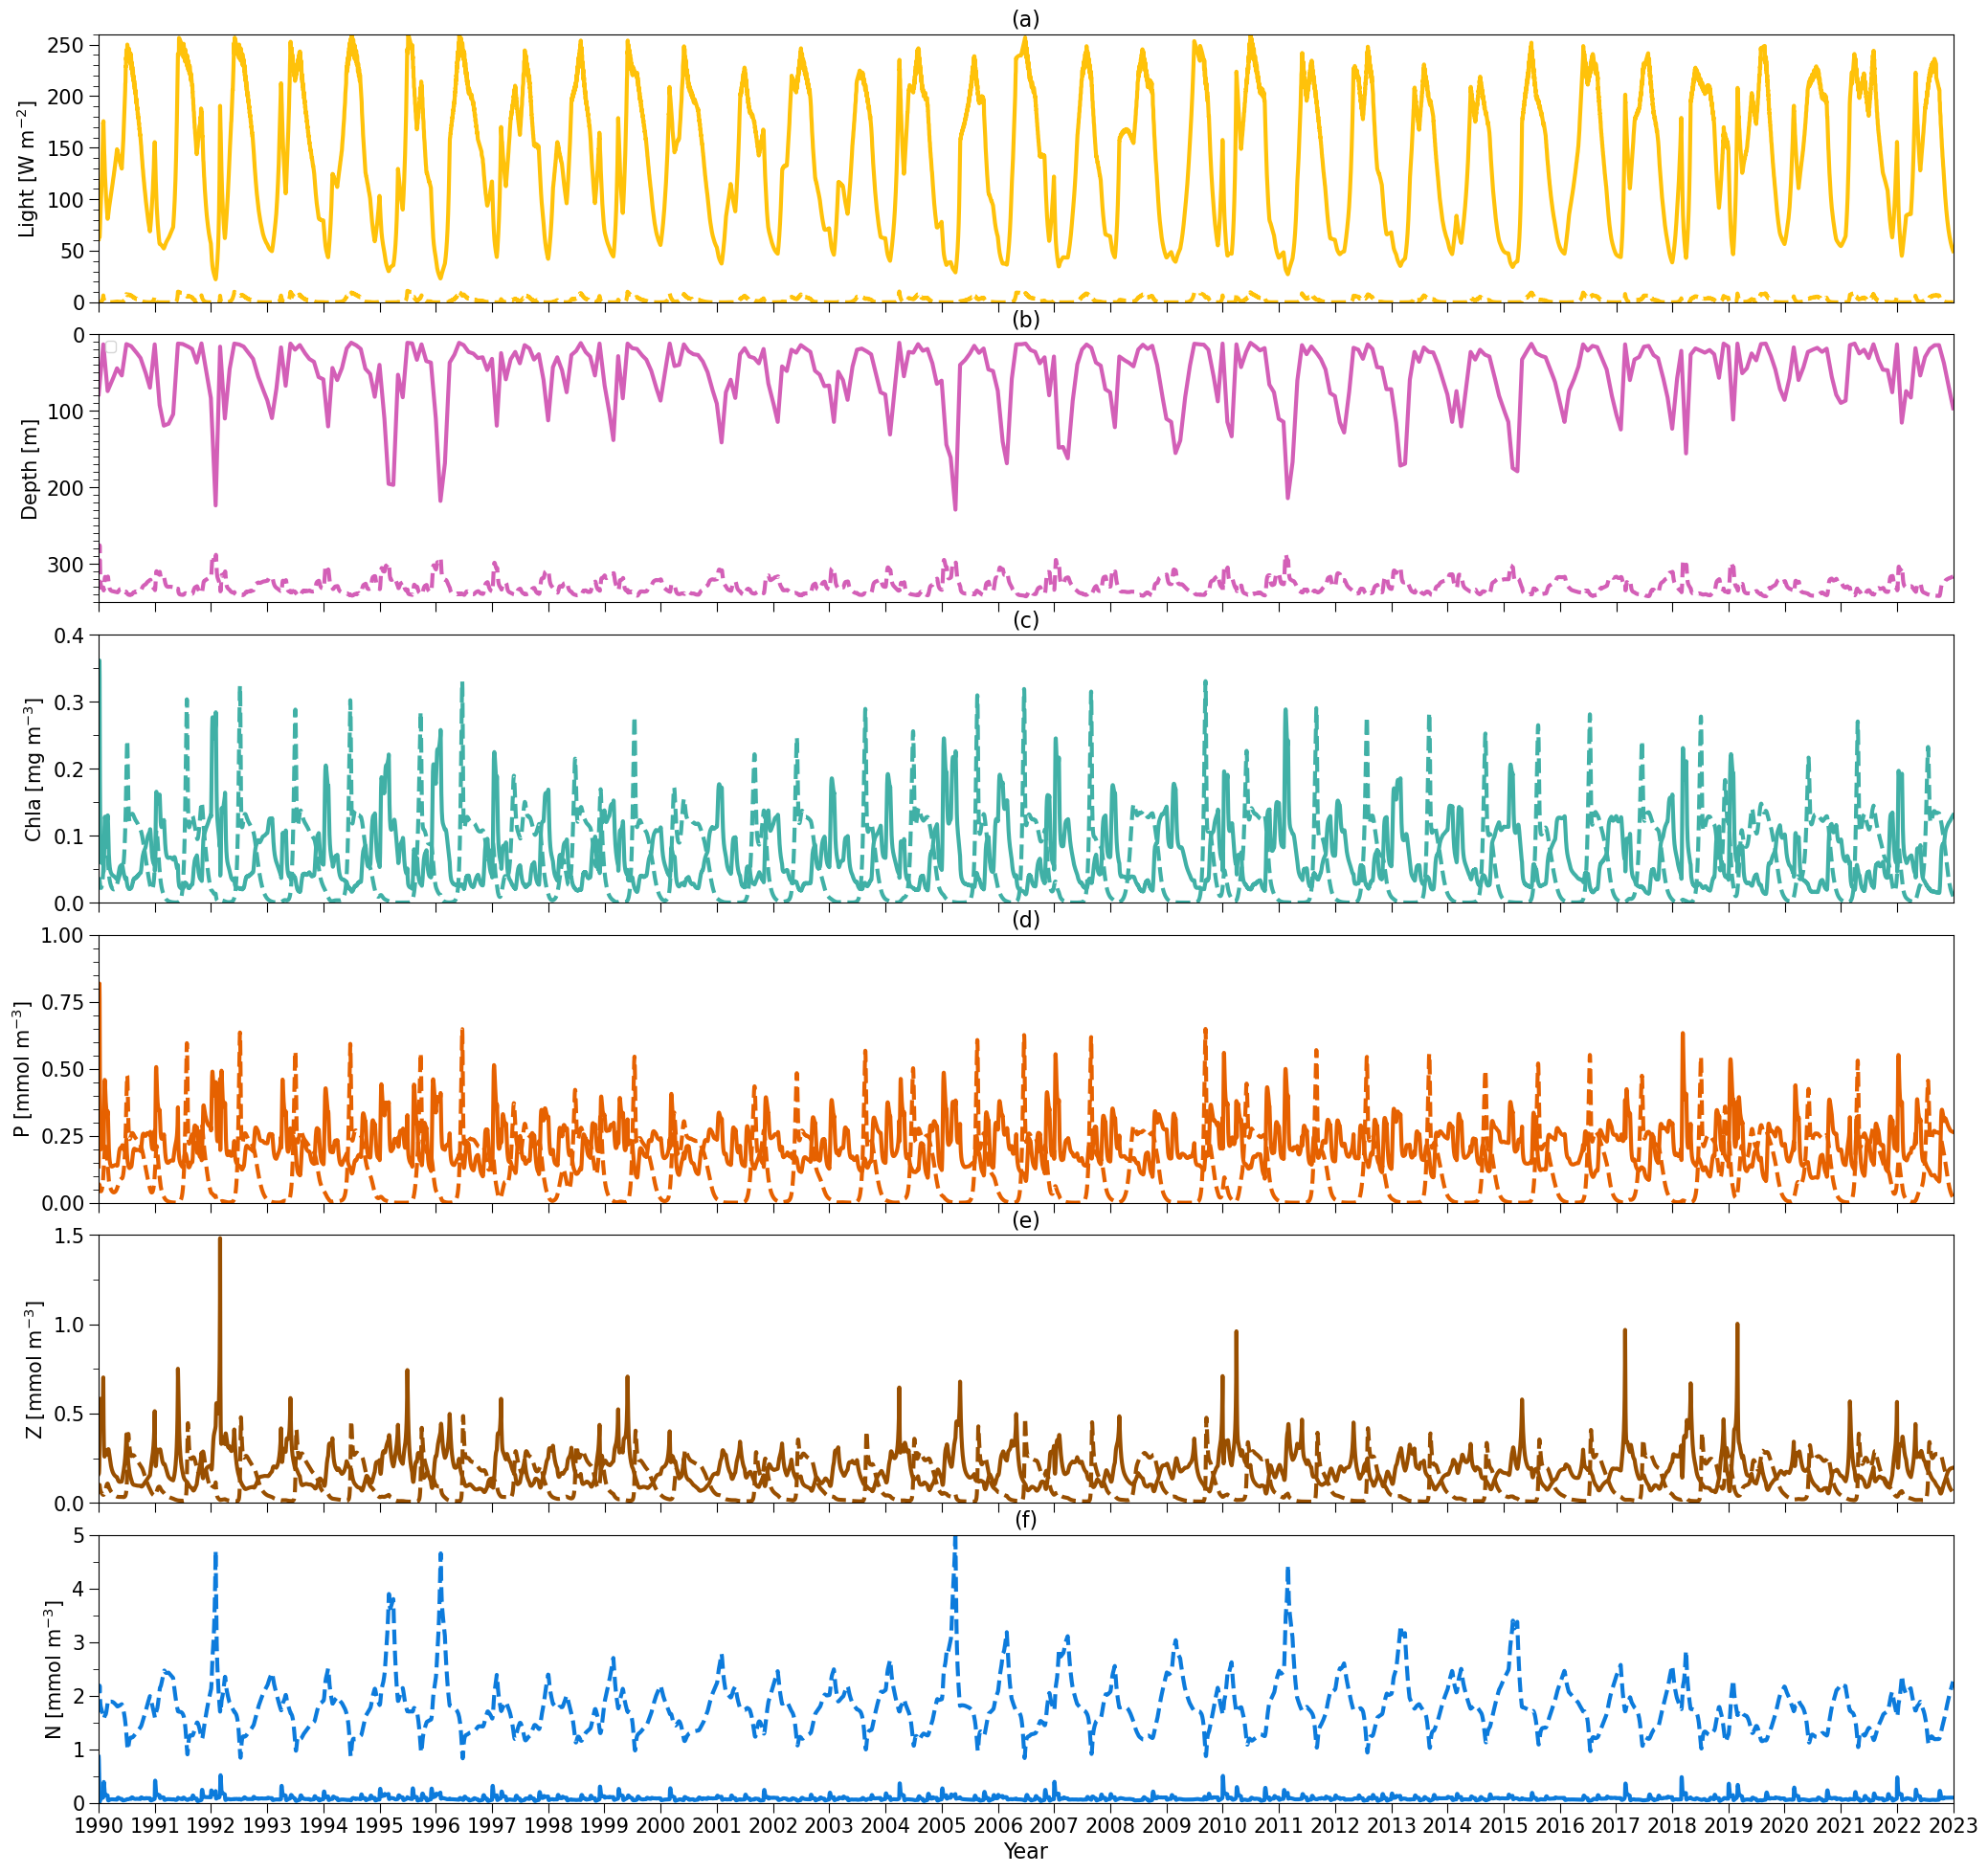

In [16]:
blue='#0C7BDC'
purple='#5D3A9B'
brown='#994F00'
red='#D35FB7'
green='#40B0A6'
yellow='#FFC20A'
orange='#E66100'
t=pd.to_datetime('2023-01-01',format='%Y-%m-%d') #have a check 
fig = plt.figure(figsize=[25,24])
plt.clf()
widths = [10]
heights = [2,2,2,2,2,2]
spec5 = fig.add_gridspec(ncols=1, nrows=6, width_ratios=widths,
                        height_ratios=heights, wspace=0.08, hspace=0.12) 

ax_current = fig.add_subplot(spec5[0,0])
#ax_current.plot(date_mld,Pstr+Nutstr+Zstr+Nd_str+Pstr_sub+Zstr_sub, color=darker_grey)
ax_current.plot(date_mld,I, '-' , color=yellow,linewidth=3)
ax_current.plot(date_mld,I_sub,'--',color=yellow,linewidth=3)
#ax1.set_title('Model output at BATS', fontsize=20, color='k')
ax_current.set_ylabel('Light [W m$^{-2}$]', fontsize=15, color='k')
ax_current.yaxis.set_tick_params(labelsize=15)
ax_current.xaxis.set_tick_params(labelsize=15)
ax_current.set_xlim(date_mld.min(),date_mld.max())
ax_current.set_ylim(0,260)
major_interval = 50
ax_current.tick_params(which='major', direction='out', length=7)
ax_current.yaxis.set_major_locator(MultipleLocator(major_interval))
ax_current.yaxis.set_minor_locator(AutoMinorLocator(5))
ax_current.tick_params(which='minor', direction='out', length=4)
ax_current.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_current.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax_current,xticklabels=[])
ax_current.set_title('(a)', fontsize=16)

ax_current = fig.add_subplot(spec5[1,0])
ax_current.plot(date_mld,MLD, '-', color=red,linewidth=3)
ax_current.plot(date_mld,Depth_EU, '--',color=red,linewidth=3)
ax_current.set_ylabel('Depth [m]', fontsize=15, color='k')
ax_current.invert_yaxis() 
#ax2.plot(Daystr,fl_mld, label='MLD 3 day filtered', color='k')
ax_current.yaxis.set_tick_params(labelsize=15)
ax_current.set_xlim(date_mld.min(),date_mld.max())
ax_current.legend()
major_interval = 100
ax_current.tick_params(which='major', direction='out', length=7)
ax_current.yaxis.set_major_locator(MultipleLocator(major_interval))
ax_current.yaxis.set_minor_locator(AutoMinorLocator(10))
ax_current.tick_params(which='minor', direction='out', length=4)
ax_current.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_current.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax_current,xticklabels=[])
ax_current.set_title('(b)', fontsize=16)
ax_current.set_ylim(350,0)


ax_current = fig.add_subplot(spec5[2,0])
ax_current.plot(date_mld, Chla_str,'-', color=green,linewidth=3)
ax_current.plot(date_mld, Chla_sub_str,'--',color=green,linewidth=3)
ax_current.set_ylabel('Chla [mg m$^{-3}$]', fontsize=15, color='k')
ax_current.yaxis.set_tick_params(labelsize=15)
ax_current.set_xlim(date_mld.min(),date_mld.max())
ax_current.set_ylim(0,0.4)
ax_current.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_current.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax_current,xticklabels=[])
#ax_current.set_ylim(0,1)
major_interval = 0.1
ax_current.tick_params(which='major', direction='out', length=7)
ax_current.yaxis.set_major_locator(MultipleLocator(major_interval))
ax_current.yaxis.set_minor_locator(AutoMinorLocator(2))
ax_current.tick_params(which='minor', direction='out', length=4)
ax_current.set_title('(c)', fontsize=16)

ax_current = fig.add_subplot(spec5[3,0])
ax_current.plot(date_mld, Pstr,'-', color=orange,linewidth=3)
ax_current.plot(date_mld, Pstr_sub,'--',color=orange,linewidth=3)
ax_current.set_ylabel('P [mmol m$^{-3}$]', fontsize=15, color='k')
ax_current.yaxis.set_tick_params(labelsize=15)
ax_current.set_xlim(date_mld.min(),date_mld.max())
#ax_current.set_ylim(0,200)
ax_current.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_current.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax_current,xticklabels=[])
ax_current.set_ylim(0,1)
major_interval = 0.25
ax_current.tick_params(which='major', direction='out', length=7)
ax_current.yaxis.set_major_locator(MultipleLocator(major_interval))
ax_current.yaxis.set_minor_locator(AutoMinorLocator(5))
ax_current.tick_params(which='minor', direction='out', length=4)
ax_current.set_title('(d)', fontsize=16)

ax_current = fig.add_subplot(spec5[4,0])
ax_current.plot(date_mld,Zstr,'-', color=brown,linewidth=3)
ax_current.plot(date_mld,Zstr_sub,'--',color=brown,linewidth=3)
ax_current.set_ylabel('Z [mmol m$^{-3}$]', fontsize=15, color='k')
ax_current.yaxis.set_tick_params(labelsize=15)
ax_current.set_xlim(date_mld.min(),date_mld.max())
ax_current.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_current.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax_current,xticklabels=[])
ax_current.set_ylim(0,1.5)
major_interval = 0.5
ax_current.tick_params(which='major', direction='out', length=7)
ax_current.yaxis.set_major_locator(MultipleLocator(major_interval))
ax_current.yaxis.set_minor_locator(AutoMinorLocator(2))
ax_current.tick_params(which='minor', direction='out', length=4)
ax_current.set_title('(e)', fontsize=16)

ax_current = fig.add_subplot(spec5[5,0])
ax_current.plot(date_mld,Nutstr,'-', color=blue, linewidth=3)
ax_current.plot(date_mld,Nd_str,'--', color=blue,linewidth=3 )
ax_current.set_ylabel('N [mmol m$^{-3}$]', fontsize=15, color='k')
ax_current.yaxis.set_tick_params(labelsize=15)
ax_current.set_xlim(date_mld.min(),t)
ax_current.set_xlabel('Year', fontsize=16)
ax_current.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_current.xaxis.set_major_locator(mdates.YearLocator())
ax_current.set_title('(f)', fontsize=16)
ax_current.xaxis.set_tick_params(labelsize=15)
ax_current.set_ylim(0,5)
major_interval = 1
ax_current.tick_params(which='major', direction='out', length=7)
ax_current.yaxis.set_major_locator(MultipleLocator(major_interval))
ax_current.yaxis.set_minor_locator(AutoMinorLocator(2))
ax_current.tick_params(which='minor', direction='out', length=4)